In [24]:
import torch
import torchaudio
import librosa
import resampy

print(f"torch:{torch.__version__}")
print(f"torchaudio: {torchaudio.__version__}")
print(f"librosa: {librosa.__version__}")
print(f"resampy: {resampy.__version__}")

torch:2.8.0+cu126
torchaudio: 2.8.0+cu126
librosa: 0.11.0
resampy: 0.4.3


총 4개의 m4a 파일을 찾았습니다.

=== Processing: audio_dataset\095522039.m4a ===
Waveform shape: torch.Size([1, 177152]), Sample rate: 44100


C:\Users\zkdlw\AppData\Local\Temp\ipykernel_19468\2496401550.py:110: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=None, mono=False)
c:\Users\zkdlw\AppData\Local\Programs\Python\Python313\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


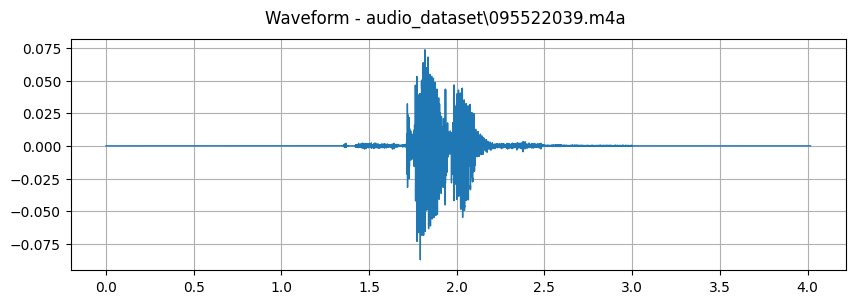

c:\Users\zkdlw\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_axes.py:8283: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


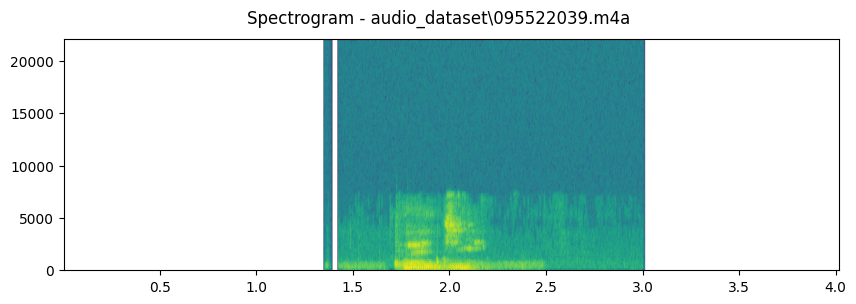

Downsampled shape: torch.Size([1, 64273]), Sample rate: 16000


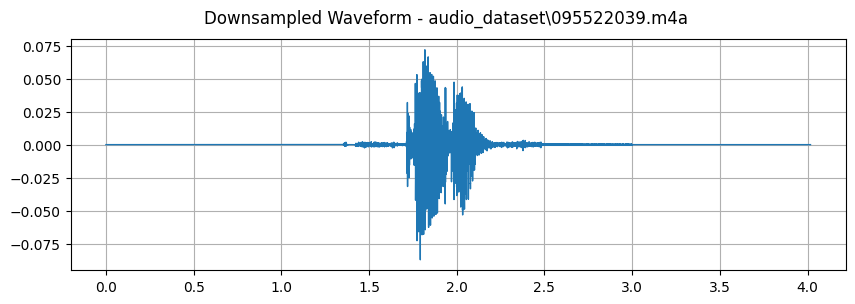

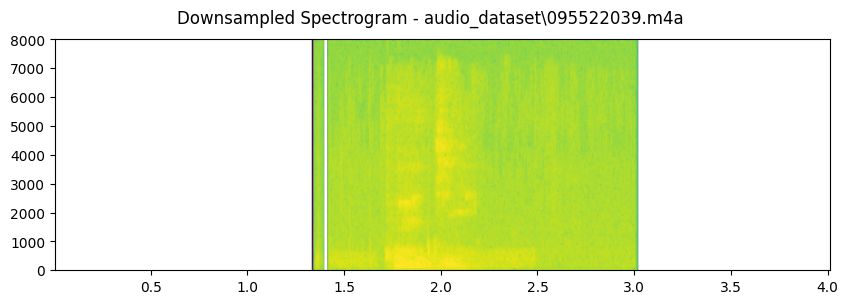

Upsampled shape: torch.Size([1, 192819]), Sample rate: 48000


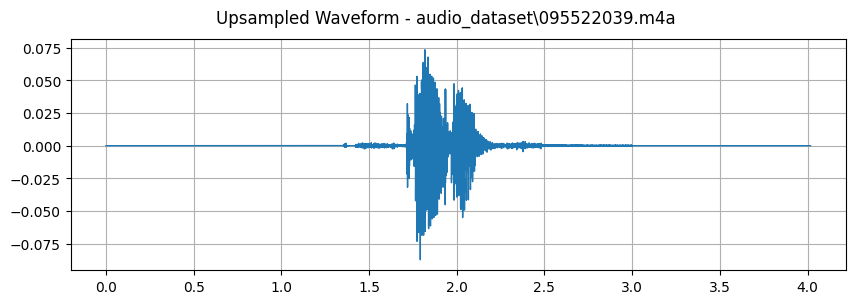

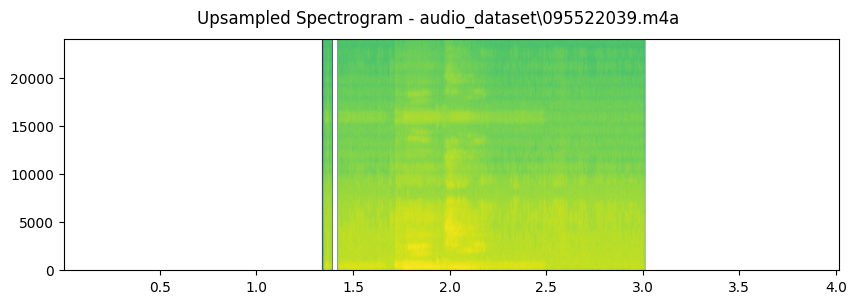


=== Processing: audio_dataset\095522040.m4a ===
Waveform shape: torch.Size([1, 177152]), Sample rate: 44100


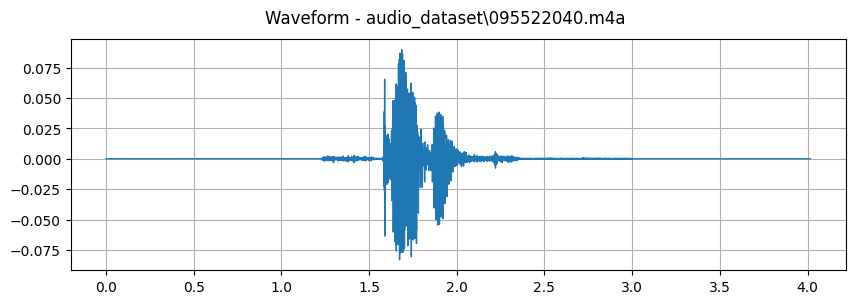

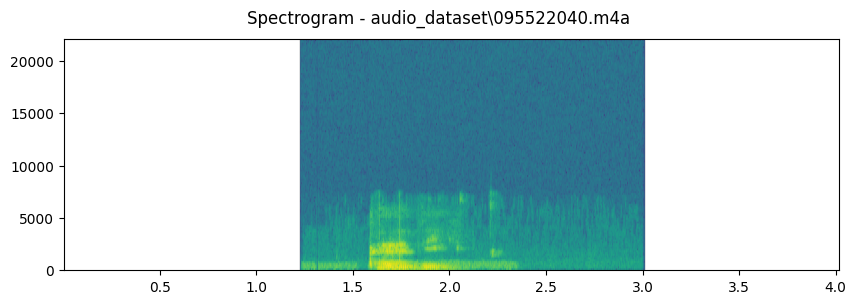

Downsampled shape: torch.Size([1, 64273]), Sample rate: 16000


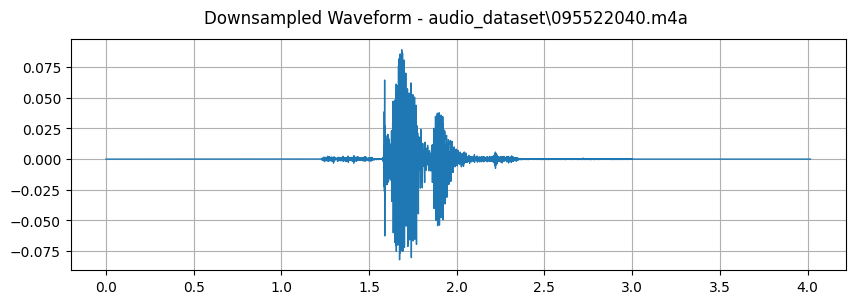

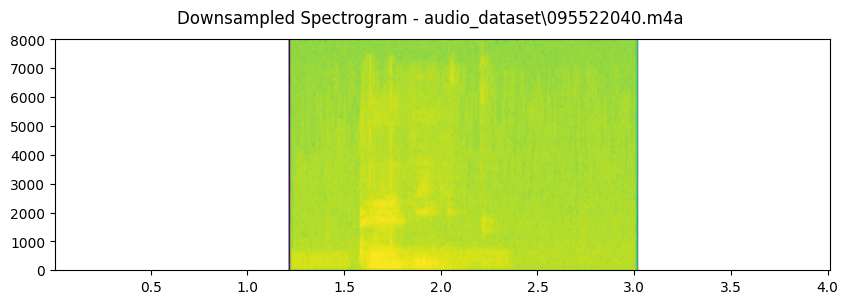

Upsampled shape: torch.Size([1, 192819]), Sample rate: 48000


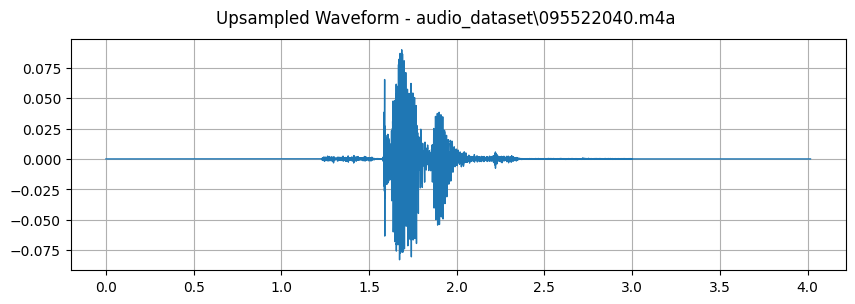

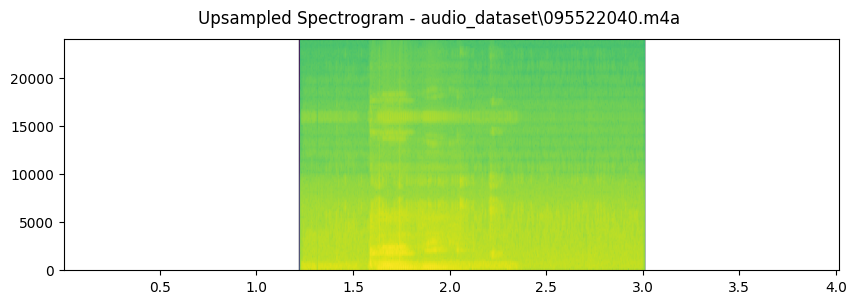


=== Processing: audio_dataset\095522041.m4a ===
Waveform shape: torch.Size([1, 177152]), Sample rate: 44100


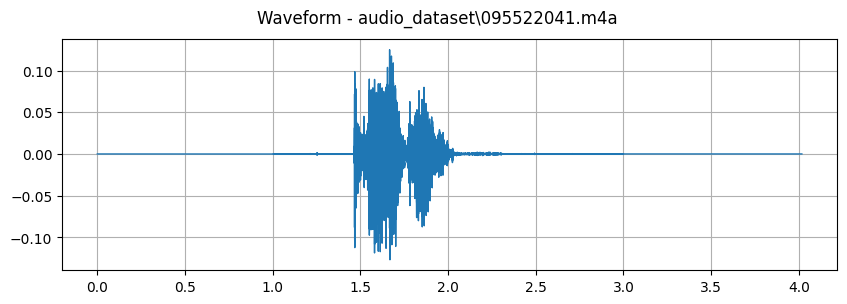

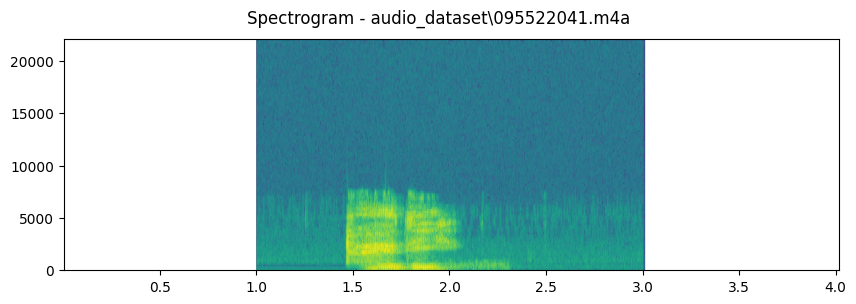

Downsampled shape: torch.Size([1, 64273]), Sample rate: 16000


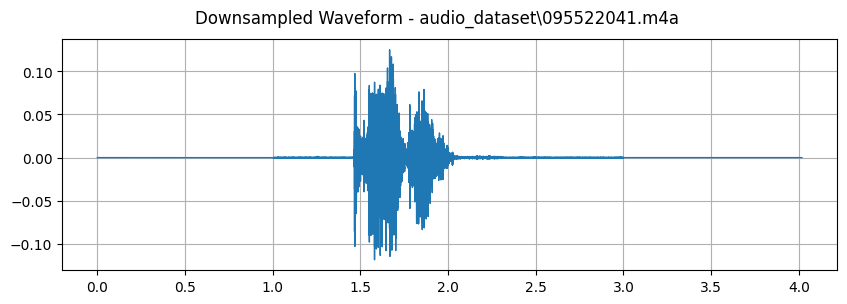

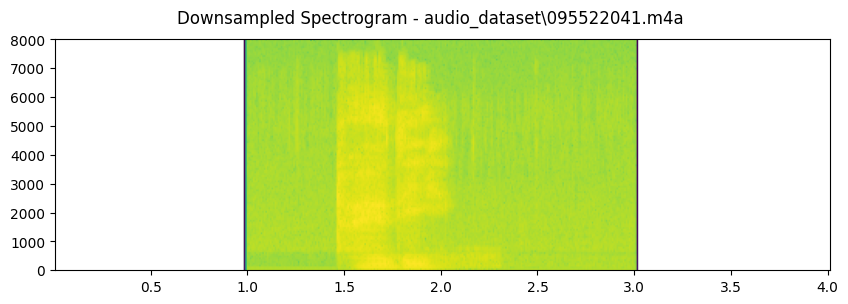

Upsampled shape: torch.Size([1, 192819]), Sample rate: 48000


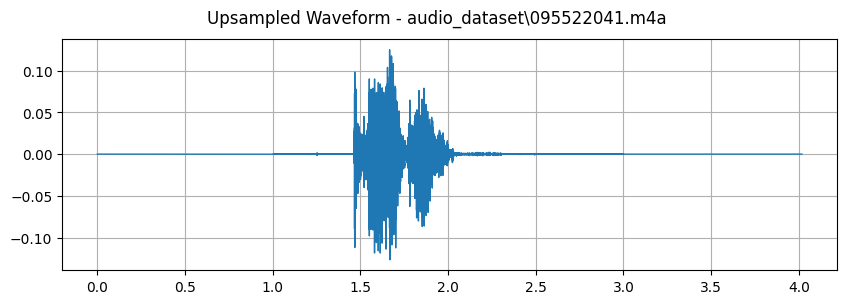

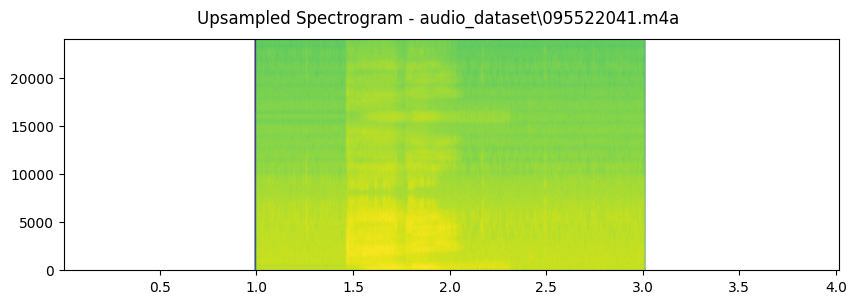


=== Processing: audio_dataset\095522042.m4a ===
Waveform shape: torch.Size([1, 177152]), Sample rate: 44100


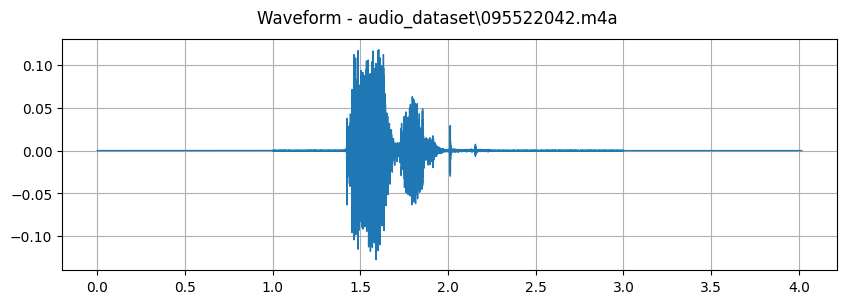

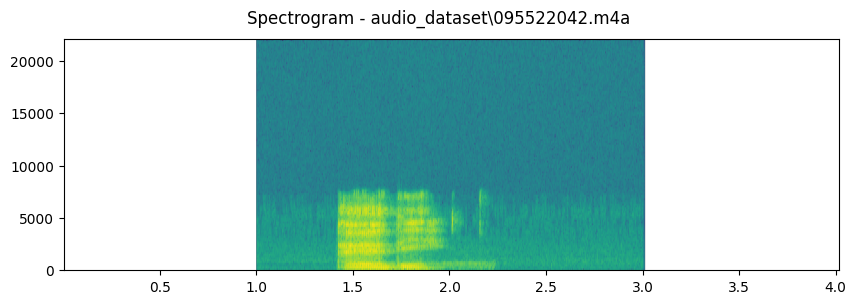

Downsampled shape: torch.Size([1, 64273]), Sample rate: 16000


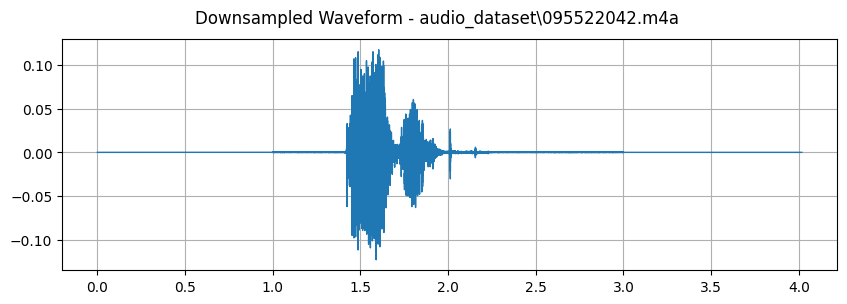

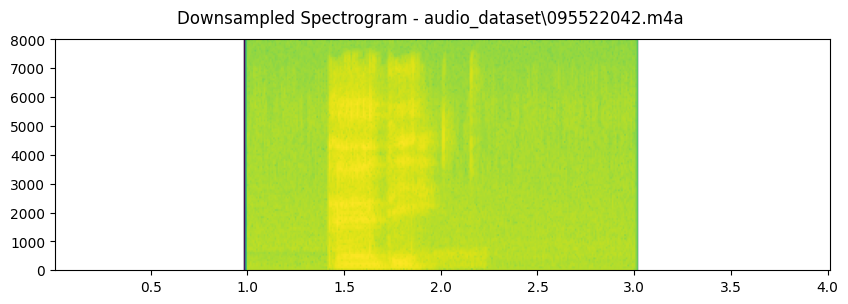

Upsampled shape: torch.Size([1, 192819]), Sample rate: 48000


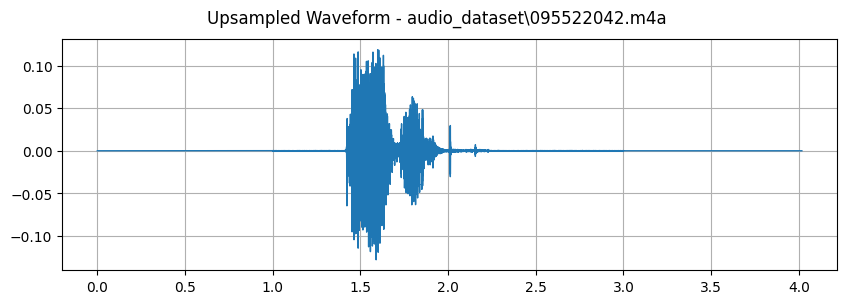

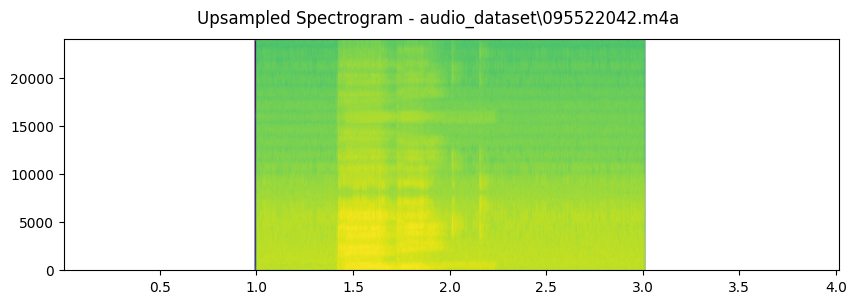

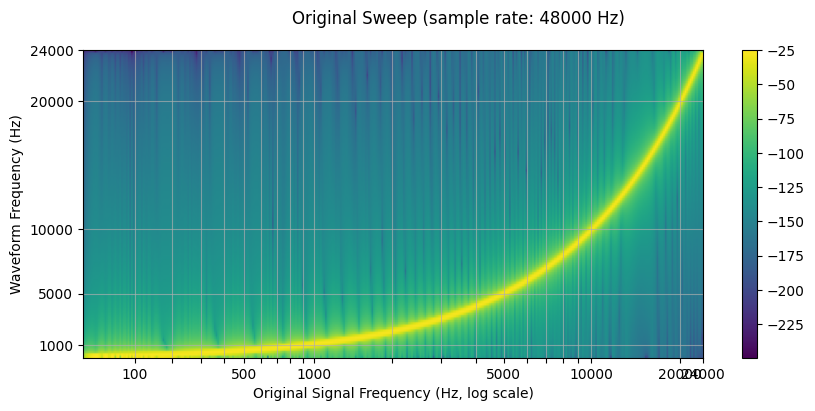

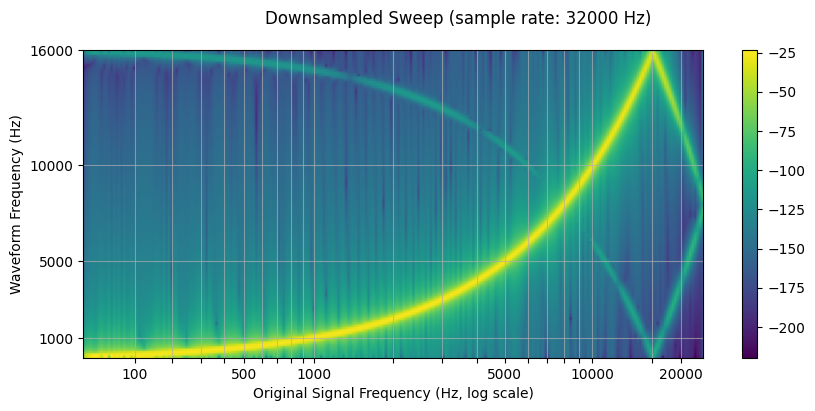

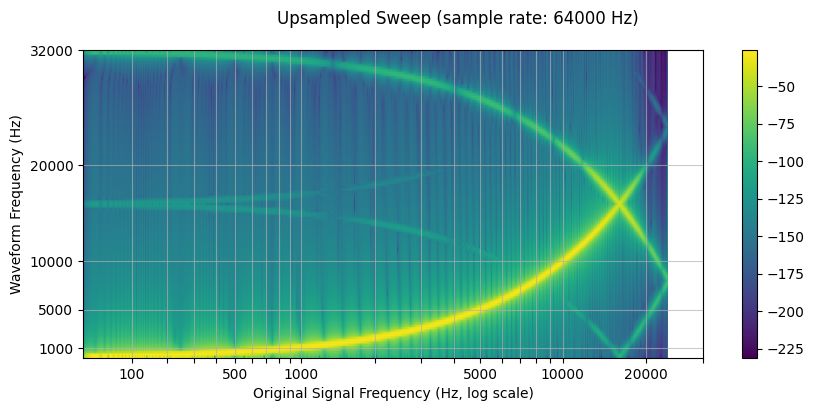

In [5]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import torch
import glob
from IPython.display import Audio, display
import torchaudio.transforms as T

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

DEFAULT_OFFSET = 201

# ====== 시각화 함수 ======
def plot_waveform(waveform, sample_rate, title="Waveform"):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize=(10, 3))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show()


def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1, figsize=(10, 3))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show()


# ====== sine sweep 관련 함수 ======
def _get_log_freq(sample_rate, max_sweep_rate, offset):
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset


def _get_inverse_log_freq(freq, sample_rate, offset):
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))


def _get_freq_ticks(sample_rate, offset, f_max):
    times, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10**exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                times.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    times.append(t_max)
    freq.append(f_max)
    return times, freq


def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal


def plot_sweep(waveform, sample_rate, title, max_sweep_rate=48000, offset=DEFAULT_OFFSET):
    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f in y_ticks and 1000 <= f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1, figsize=(10, 4))
    _, _, _, cax = axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
    axis.set_ylabel("Waveform Frequency (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.colorbar(cax)
    plt.show()


# ====== 1. m4a 파일 처리 ======
file_list = sorted(glob.glob("audio_dataset/0955220*.m4a"))
print(f"총 {len(file_list)}개의 m4a 파일을 찾았습니다.")

for path in file_list:
    print(f"\n=== Processing: {path} ===")
    y, sr = librosa.load(path, sr=None, mono=False)

    file_waveform = torch.from_numpy(y)
    if file_waveform.ndim == 1:  # mono일 경우
        file_waveform = file_waveform.unsqueeze(0)

    print(f"Waveform shape: {file_waveform.shape}, Sample rate: {sr}")

    plot_waveform(file_waveform, sr, title=f"Waveform - {path}")
    plot_specgram(file_waveform, sr, title=f"Spectrogram - {path}")
    display(Audio(file_waveform.numpy()[0], rate=sr))

    # 다운샘플링 (예: 16kHz)
    down_rate = 16000
    resampler_down = T.Resample(sr, down_rate, dtype=file_waveform.dtype)
    downsampled = resampler_down(file_waveform)
    print(f"Downsampled shape: {downsampled.shape}, Sample rate: {down_rate}")
    plot_waveform(downsampled, down_rate, title=f"Downsampled Waveform - {path}")
    plot_specgram(downsampled, down_rate, title=f"Downsampled Spectrogram - {path}")
    display(Audio(downsampled.numpy()[0], rate=down_rate))

    # 업샘플링 (다운샘플링한 걸 다시 48kHz로 올리기)
    up_rate = 48000
    resampler_up = T.Resample(down_rate, up_rate, dtype=downsampled.dtype)
    upsampled = resampler_up(downsampled)
    print(f"Upsampled shape: {upsampled.shape}, Sample rate: {up_rate}")
    plot_waveform(upsampled, up_rate, title=f"Upsampled Waveform - {path}")
    plot_specgram(upsampled, up_rate, title=f"Upsampled Spectrogram - {path}")
    display(Audio(upsampled.numpy()[0], rate=up_rate))


# ====== 2. sine sweep 신호 생성 및 실험 ======
sweep_rate = 48000
sweep_waveform = get_sine_sweep(sweep_rate)

plot_sweep(sweep_waveform, sweep_rate, title="Original Sweep")
display(Audio(sweep_waveform.numpy()[0], rate=sweep_rate))

# 다운샘플링 (48k → 32k)
resample_rate = 32000
resampler = T.Resample(sweep_rate, resample_rate, dtype=sweep_waveform.dtype)
resampled_sweep = resampler(sweep_waveform)

plot_sweep(resampled_sweep, resample_rate, title="Downsampled Sweep")
display(Audio(resampled_sweep.numpy()[0], rate=resample_rate))

# 업샘플링 (32k → 64k)
up_rate = 64000
resampler_up = T.Resample(resample_rate, up_rate, dtype=resampled_sweep.dtype)
upsampled_sweep = resampler_up(resampled_sweep)

plot_sweep(upsampled_sweep, up_rate, title="Upsampled Sweep")
display(Audio(upsampled_sweep.numpy()[0], rate=up_rate))
